# DATA CLEANING (TECHNICAL CODING ROUND)
__ Creator : Rahul Muliana - SDE __

In [ ]:
# Setting up the PySpark environment

# Install java 8
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Apache Spark binary: This link can change based on the version. Update this link with the latest version before using
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# Unzip file
!tar -xf spark-3.1.2-bin-hadoop3.2.tgz

# Install findspark: Adds Pyspark to sys.path at runtime
!pip install -q findspark

# Install pyspark
!pip install pyspark

# Add environmental variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

# findspark will locate spark in the system
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [543 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ge

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .getOrCreate()

### __IMPORT THE DATASET__ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/IYKRA/#10/Task_2/BL-Flickr-Images-Book.csv"
spark_df = spark.read.format('csv').options(header='true', inferSchema='true').load(filepath)

#### __READING THE FIRST FEW ENTRIES OF THE DATASET__

In [ ]:
spark_df.show(5, truncate=False)

+----------+----------------------------+------------------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------+----------------+----------------------+------------+--------+-------------+----------------------------------------------------------------+-----------------------------------+
|Identifier|Edition Statement           |Place of Publication    |Date of Publication|Publisher            |Title                                                                                                                                                           |Author   |Contributors                                |Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|Flickr URL                                                      |Shelfmarks                       

In [ ]:
#check the missing values
from pyspark.sql.functions import isnan, when, count, col
 
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------------+----------+----------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|Publisher|Title|Author|Contributors|Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|Flickr URL|Shelfmarks|
+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------------+----------+----------+
|         0|             7514|                   0|                181|     4195|    0|  1776|           2|            8276|                  8282|        8282|    8284|           10|         5|         4|
+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------

In [ ]:
spark_df.filter(col('Shelfmarks').isNull()).show()

+----------+-----------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+----------+----------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|  Publisher|               Title|              Author|        Contributors|    Corporate Author|Corporate Contributors|        Former owner|            Engraver|       Issuance type|Flickr URL|Shelfmarks|
+----------+-----------------+--------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+----------+----------+
|    867581|             null|              London|               1845|Jeremia How|"A Brief Narrativ...|"" near the mouth...| on the 4th November|                1843|   ha

In [ ]:
spark_df.filter(col('Issuance type').isNull()).show()

+----------+-----------------+--------------------+-------------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+-----------+--------------------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|       Publisher|               Title|              Author|        Contributors|    Corporate Author|Corporate Contributors|        Former owner|            Engraver|Issuance type| Flickr URL|          Shelfmarks|
+----------+-----------------+--------------------+-------------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+-----------+--------------------+
|    606685|             null|              London|            [1850?]|Edward Smallwood|"A History of Car...| Isle of Wight"" ...|               

In [ ]:
spark_df.filter(col('Contributors').isNull()).show()

+----------+-----------------+--------------------+-------------------+----------------+--------------------+--------------------+------------+--------------------+----------------------+------------+--------+-------------+-----------+--------------------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|       Publisher|               Title|              Author|Contributors|    Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type| Flickr URL|          Shelfmarks|
+----------+-----------------+--------------------+-------------------+----------------+--------------------+--------------------+------------+--------------------+----------------------+------------+--------+-------------+-----------+--------------------+
|    606685|             null|              London|            [1850?]|Edward Smallwood|"A History of Car...| Isle of Wight"" ...|        null|    Westall, William|                  null|        null|    null|         null|monogr

## Cleaning the messy columns

 __Some data entries are really messy and needs to be cleaned as they contain several values which makes it hard to analyse the data __

__ The Date of Publication column is slightly messy. It would be better if we only had years in the column. Let us see how you can clean it __

In [ ]:
pandas_df = spark_df.toPandas()
pandas_df.shape

(8287, 15)

In [ ]:
# make DEF Function
unwanted_characters = ['[', ',', '-']

def clean_dates(dop):
    dop = str(dop)
    if dop.startswith('[') or dop == 'nan':
        return 'NaN'
    for character in unwanted_characters:
        if character in dop:
            character_index = dop.find(character)
            dop = dop[:character_index]
    return dop

In [ ]:
pandas_df['Date of Publication'] = pandas_df['Date of Publication'].apply(clean_dates)
pandas_df.head()

,Identifier,Edition Statement,Place of Publication,Date of Publication,Publisher,Title,Author,Contributors,Corporate Author,Corporate Contributors,Former owner,Engraver,Issuance type,Flickr URL,Shelfmarks
0,206,None,London,1879,S. Tinsley & Co.,Walter Forbes. [A novel.] By A. A,A. A.,"FORBES, Walter.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12641.b.30.
1,216,None,London; Virtue & Yorston,1868,Virtue & Co.,All for Greed. [A novel. The dedication signed...,"A., A. A.","BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12626.cc.2.
2,218,None,London,1869,"Bradbury, Evans & Co.",Love the Avenger. By the author of “All for Gr...,"A., A. A.","BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12625.dd.1.
3,472,None,London,1851,James Darling,"Welsh Sketches, chiefly ecclesiastical, to the...","A., E. S.","Appleyard, Ernest Silvanus.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 10369.bbb.15.
4,480,"A new edition, revised, etc.",London,1857,Wertheim & Macintosh,"[The World in which I live, and my place in it...","A., E. S.","BROOME, John Henry.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 9007.d.28.


In [ ]:
spark_df1 = spark.createDataFrame(pandas_df)
spark_df1.show(3)

+----------+-----------------+--------------------+-------------------+--------------------+--------------------+---------+--------------------+----------------+----------------------+------------+--------+-------------+--------------------+--------------------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|           Publisher|               Title|   Author|        Contributors|Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|          Flickr URL|          Shelfmarks|
+----------+-----------------+--------------------+-------------------+--------------------+--------------------+---------+--------------------+----------------+----------------------+------------+--------+-------------+--------------------+--------------------+
|       206|             null|              London|              1879 |    S. Tinsley & Co.|Walter Forbes. [A...|    A. A.|     FORBES, Walter.|            null|                  null|        null|    null|  mon

__ The next such column is the 'Title' column. Let us try to clean that column now. __

In [ ]:
# make DEF Function
def clean_title(title):
    
    if title == 'nan':
        return 'NaN'
    
    if title[0] == '[':
        title = title[1: title.find(']')]
        
    if 'by' in title:
        title = title[:title.find('by')]
    elif 'By' in title:
        title = title[:title.find('By')]
        
    if '[' in title:
        title = title[:title.find('[')]

    title = title[:-2]
        
    title = list(map(str.capitalize, title.split()))
    return ' '.join(title)

In [ ]:
pandas_df2 = spark_df1.toPandas()
pandas_df2['Title'] = pandas_df2['Title'].apply(clean_title)

In [ ]:
spark_df2 = spark.createDataFrame(pandas_df2)
spark_df2.show(3)

+----------+-----------------+--------------------+-------------------+--------------------+----------------+---------+--------------------+----------------+----------------------+------------+--------+-------------+--------------------+--------------------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|           Publisher|           Title|   Author|        Contributors|Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|          Flickr URL|          Shelfmarks|
+----------+-----------------+--------------------+-------------------+--------------------+----------------+---------+--------------------+----------------+----------------------+------------+--------+-------------+--------------------+--------------------+
|       206|             null|              London|              1879 |    S. Tinsley & Co.|   Walter Forbes|    A. A.|     FORBES, Walter.|            null|                  null|        null|    null|  monographic|http://

__ The 'Author' column needs to be tweaked a little too __

In [ ]:
# make DEF Function
from functools import reduce

# make DEF Function
def clean_author_names(author):
    
    author = str(author)
    
    if author == 'nan':
        return 'NaN'
    
    author = author.split(',')

    if len(author) == 1:
        name = filter(lambda x: x.isalpha(), author[0])
        return reduce(lambda x, y: x + y, name)
    
    last_name, first_name = author[0], author[1]

    first_name = first_name[:first_name.find('-')] if '-' in first_name else first_name
    
    if first_name.endswith(('.', '.|')):
        parts = first_name.split('.')
        
        if len(parts) > 1:
            first_occurence = first_name.find('.')
            final_occurence = first_name.find('.', first_occurence + 1)
            first_name = first_name[:final_occurence]
        else:
            first_name = first_name[:first_name.find('.')]
    
    last_name = last_name.capitalize()
    
    return f'{first_name} {last_name}'

In [ ]:
pandas_df3 = spark_df2.toPandas()
pandas_df3.shape

(8287, 15)

In [ ]:
pandas_df3['Author'] = pandas_df3['Author'].apply(clean_author_names)
pandas_df3.head(3)

,Identifier,Edition Statement,Place of Publication,Date of Publication,Publisher,Title,Author,Contributors,Corporate Author,Corporate Contributors,Former owner,Engraver,Issuance type,Flickr URL,Shelfmarks
0,206,None,London,1879,S. Tinsley & Co.,Walter Forbes,AA,"FORBES, Walter.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12641.b.30.
1,216,None,London; Virtue & Yorston,1868,Virtue & Co.,All For Greed,A. A A.,"BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12626.cc.2.
2,218,None,London,1869,"Bradbury, Evans & Co.",Love The Avenger,A. A A.,"BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12625.dd.1.


In [ ]:
spark_df3 = spark.createDataFrame(pandas_df3)
spark_df3.show(3, truncate= False)

+----------+-----------------+------------------------+-------------------+---------------------+----------------+--------+--------------------------------------------+----------------+----------------------+------------+--------+-------------+----------------------------------------------------------------+---------------------------------+
|Identifier|Edition Statement|Place of Publication    |Date of Publication|Publisher            |Title           |Author  |Contributors                                |Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|Flickr URL                                                      |Shelfmarks                       |
+----------+-----------------+------------------------+-------------------+---------------------+----------------+--------+--------------------------------------------+----------------+----------------------+------------+--------+-------------+----------------------------------------------------------------+---

__ The 'Place of publication' has a few complications too. Especially with places containing London and Oxford. __

In [ ]:
# make DEF Function
def place(x):
    if 'London' in x['Place of Publication']:
      return 'London'
    elif 'Oxford' in x['Place of Publication']:
      return 'Oxford'
    elif 'Newcastle upon Tyne' in x['Place of Publication'] :
      return 'Newcastle-upon-Tyne'
    else :
      pass

In [ ]:
pandas_df4 = spark_df3.toPandas()
pandas_df4.shape

(8287, 15)

In [ ]:
pandas_df4['Place of Publication'] = pandas_df4.apply(lambda x: place(x), axis=1)
pandas_df4.head()

,Identifier,Edition Statement,Place of Publication,Date of Publication,Publisher,Title,Author,Contributors,Corporate Author,Corporate Contributors,Former owner,Engraver,Issuance type,Flickr URL,Shelfmarks
0,206,None,London,1879,S. Tinsley & Co.,Walter Forbes,AA,"FORBES, Walter.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12641.b.30.
1,216,None,London,1868,Virtue & Co.,All For Greed,A. A A.,"BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12626.cc.2.
2,218,None,London,1869,"Bradbury, Evans & Co.",Love The Avenger,A. A A.,"BLAZE DE BURY, Marie Pauline Rose - Baroness",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 12625.dd.1.
3,472,None,London,1851,James Darling,"Welsh Sketches, Chiefly Ecclesiastical, To The...",E. S A.,"Appleyard, Ernest Silvanus.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 10369.bbb.15.
4,480,"A new edition, revised, etc.",London,1857,Wertheim & Macintosh,"The World In Which I Live, And My Place In It",E. S A.,"BROOME, John Henry.",None,None,None,None,monographic,http://www.flickr.com/photos/britishlibrary/ta...,British Library HMNTS 9007.d.28.


In [ ]:
spark_df4 = spark.createDataFrame(pandas_df4)
spark_df4.show(10, truncate= False)

+----------+-----------------------------+--------------------+-------------------+---------------------+---------------------------------------------------------------------------+--------+--------------------------------------------+----------------+----------------------+------------+--------+-------------+----------------------------------------------------------------+--------------------------------------+
|Identifier|Edition Statement            |Place of Publication|Date of Publication|Publisher            |Title                                                                      |Author  |Contributors                                |Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|Flickr URL                                                      |Shelfmarks                            |
+----------+-----------------------------+--------------------+-------------------+---------------------+---------------------------------------------------------------

### Detecting missing values and dealing with them
__The missing values could be in many ways. Most common ways of missing values are the NaN values or nothing at all being present in the entries. Let us first look at what to do with the NaN / NULL / Blank Character values__

__Let us first count the number of values which are NaN / NULL / Blank Character and etc__

In [ ]:
#check the missing values
from pyspark.sql.functions import isnan, when, count, col

spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------------+----------+----------+
|Identifier|Edition Statement|Place of Publication|Date of Publication|Publisher|Title|Author|Contributors|Corporate Author|Corporate Contributors|Former owner|Engraver|Issuance type|Flickr URL|Shelfmarks|
+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------------+----------+----------+
|         0|             7514|                   0|                181|     4195|    0|  1776|           2|            8276|                  8282|        8282|    8284|           10|         5|         4|
+----------+-----------------+--------------------+-------------------+---------+-----+------+------------+----------------+----------------------+------------+--------+-------

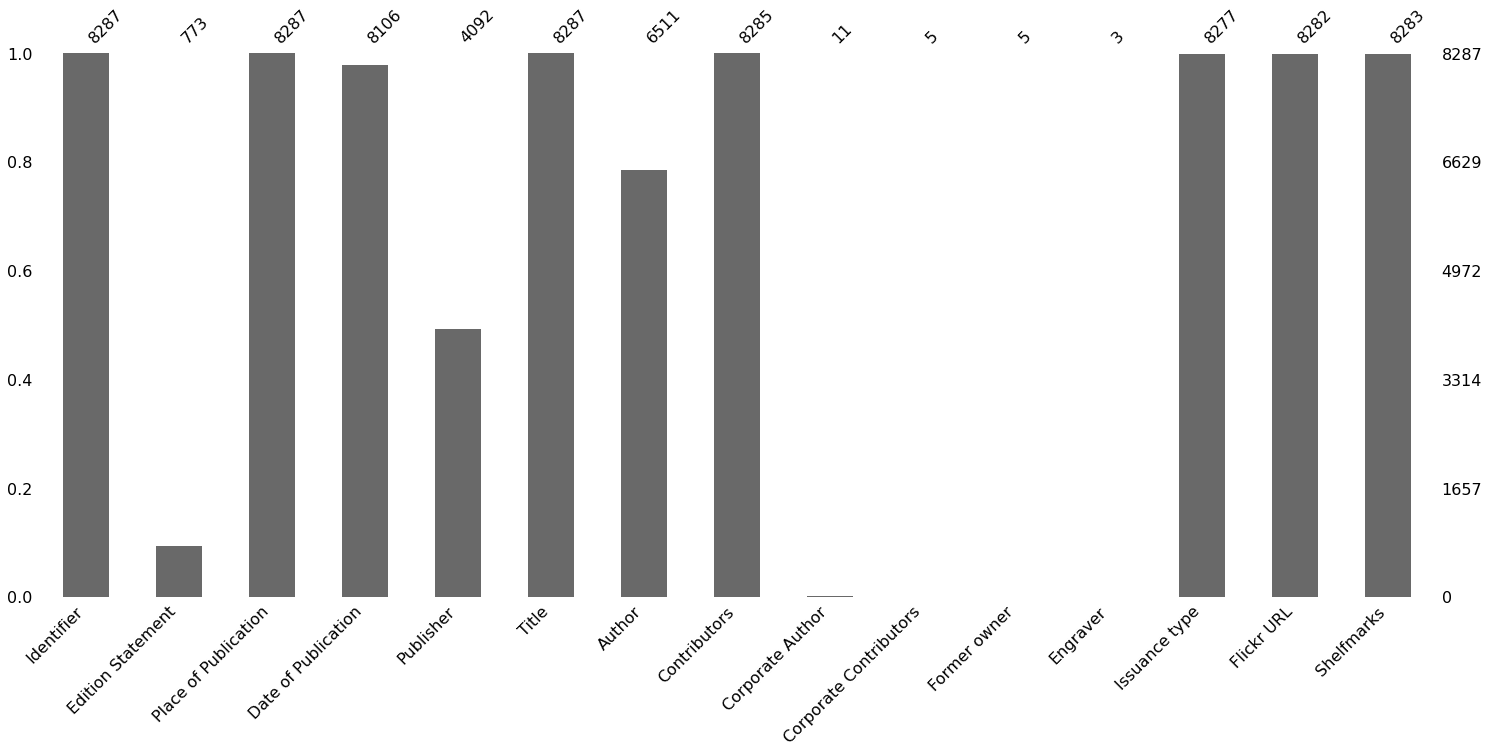

In [ ]:
import missingno as msno
msno.bar(spark_df.toPandas())

In [ ]:
#DROP NULL
columns_to_drop = ['Edition Statement',
           'Corporate Author',
           'Corporate Contributors',
           'Former owner',
           'Engraver']
spark_df_ = spark_df.drop(*columns_to_drop)
spark_df_.show(10, truncate= False)

+----------+-----------------------------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------------------------------------------+-------------+----------------------------------------------------------------+--------------------------------------+
|Identifier|Place of Publication               |Date of Publication|Publisher            |Title                                                                                                                                                           |Author       |Contributors                                |Issuance type|Flickr URL                                                      |Shelfmarks                            |
+----------+-----------------------------------+-------------------+---------------------+----------------------------------------------------

In [ ]:
spark_df.describe().show()

+-------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|        Identifier|   Edition Statement|Place of Publication| Date of Publication|          Publisher|               Title|              Author|        Contributors|  Corporate Author|Corporate Contributors|        Former owner|            Engraver|       Issuance type|          Flickr URL|          Shelfmarks|
+-------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              8287|      